In [189]:
import sys
import pickle
import nltk
from nltk.stem import PorterStemmer
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
sys.path.insert(0, '..')
from nltk.tokenize import word_tokenize
ps = PorterStemmer()
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gxb18167\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [190]:
with open('EEG_Text_Pairs.pkl', 'rb') as file:
    EEG_word_level_embeddings = pickle.load(file)
    train_data = pickle.load(file)

In [191]:
with open('Target_Pred_Strings.pickle', 'rb') as f:
    data = pickle.load(f)

In [192]:
target_string_list = data['Target_String']

In [193]:
predicted_string_list = data['Predicted_String']

In [233]:
def get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False):
    Correct_Predictions = {}
    counter_list = []

    train_string = " ".join(train_data)
    train_string_tokenized = word_tokenize(train_string)

    if stemming == True:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(ps.stem(w))
    else:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(w)



    for i in range(len(target_string_list)):
        target_string = target_string_list[i]
        predicted_string = predicted_string_list[i]

        predicted_string = predicted_string[0:len(target_string)]

        target_tokenized = word_tokenize(target_string)

        #print(target_tokenized)
        predicted_tokenized = word_tokenize(predicted_string)

        if stemming == True:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(ps.stem(w))
                counter_list.append(ps.stem(w))
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(ps.stem(w))
        else:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(w)
                counter_list.append(w)
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(w)

        if strict == False:
            for word in target_tokenized_stemmed:
                if word in predicted_tokenized_stemmed:
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
        else:
            min_length = min(len(predicted_tokenized_stemmed), len(target_tokenized_stemmed))
            for i in range(min_length):
                if target_tokenized_stemmed[i] == predicted_tokenized_stemmed[i]:
                    word = target_tokenized_stemmed[i]
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1

    target_word_counter = Counter(counter_list)
    word_frequency = Counter(train_string_tokenized_stemmed)

    common_keys = set(target_word_counter.keys()) & set(word_frequency.keys())
    word_frequency = {k: word_frequency[k] for k in common_keys}


    return Correct_Predictions, word_frequency


In [255]:
Correct_Predictions, word_frequency = get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False)

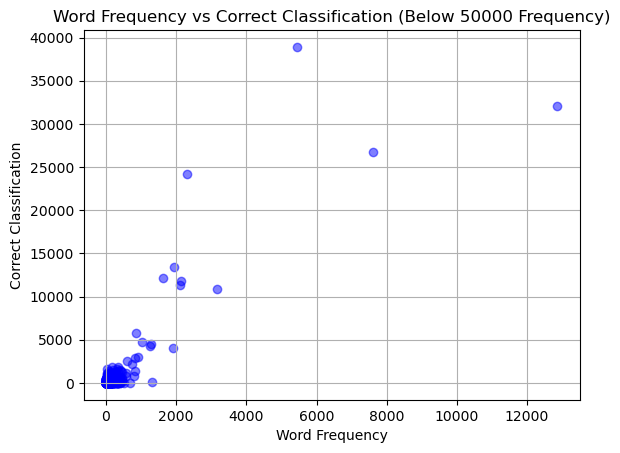

In [256]:
import matplotlib.pyplot as plt
# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]

# Create a scatter plot
plt.scatter(filtered_frequencies, filtered_classifications, color='blue', alpha=0.5)

# Customize the plot
plt.title('Word Frequency vs Correct Classification (Below {} Frequency)'.format(frequency_threshold))
plt.xlabel('Word Frequency')
plt.ylabel('Correct Classification')
plt.grid(True)
plt.show()